In [100]:
import UtilityFunctions as uf
import cv2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
import numpy as np
import pandas as pd
from ellipse import LsqEllipse
import scipy.stats as stats
from matplotlib.patches import Ellipse
import itertools as itr

In [99]:
def open_ephys_events_parser(open_ephys_csv_path, channel_names, export_path=None):
    """
    :param open_ephys_csv_path: The path to an open ephys analysis tools exported csv (using TrialReporter.ipynb)
    :param channel_names: a dictionary of the form -
                    { 1 : 'channel name' (L_eye_camera)
                      2 : 'channel name' (Arena_TTL)
                      etc..
                    }
    :param export_path: default None, if a path is specified a csv file will be saved
    :returns open_ephys_events: a pandas DataFrame object where each column has the ON events of one channel and has a title from channel_names
    """

    # Infer the active channels:
    df = pd.read_csv(open_ephys_csv_path)
    channels = df['channel'].to_numpy(copy=True)
    channels = np.unique(channels)
    df_onstate = df[df['state'] == 1]  # cut the df to represent only rising edges
    list = []
    for chan in channels:  # extract a pandas series of the ON stats timestamps for each channel
        Sname = channel_names[chan]
        s = pd.Series(df_onstate['timestamp'][df_onstate['channel'] == chan], name=Sname)
        list.append(s)
    open_ephys_events = pd.concat(list, axis=1)
    if export_path is not None:
        open_ephys_events.to_csv(export_path)
    return open_ephys_events


def get_frame_timeseries(df, channel):
    index_range = range(0, len(df[channel][df[channel].notna()]))
    timeseries = pd.Series(df[channel][df[channel].notna()])
    timeseries = pd.Series(timeseries.values, index=index_range, name=channel)

    return timeseries


def get_frame_from_time(vid_timeseries, timestamp):
    array = np.abs((vid_timeseries.to_numpy())-timestamp)
    index_of_lowest_diff = np.argmin(array)
    accuracy = abs(vid_timeseries[index_of_lowest_diff] - timestamp)
    return index_of_lowest_diff, accuracy


def TTL_timeseries_synchronization(ts_list, anchor_vid_position):
    """
    param: ts_list: list of timeseries (one for each video) representing rising edge events in the open ephys file
    param: anchor_vid_position: the video from the ts_list to use as a sync reference (all other video frames will be fitted to this video)
    returns: synchronized_ttls: np.array where each column represents a video and each row represents the best fit for the anchor video frames (timewise)
    """
    anchor_vid = ts_list[anchor_vid_position].to_numpy()
    synchronized_ttls = []
    synchronization_accuracy = []
    for frame in range(len(anchor_vid)):
        time = anchor_vid[frame]
        if frame % 50 == 0:
            print(f'frame {frame} out of {len(anchor_vid)}', end='\r', flush=True)
        sync_frame = []
        sync_accuracy = []
        for vid in ts_list:
            f, a = get_frame_from_time(vid, time)
            sync_frame.append(f)
            sync_accuracy.append(a)
        synchronized_ttls.append(sync_frame)
        synchronization_accuracy.append(sync_accuracy)
    synchronized_ttls = np.array(synchronized_ttls)
    synchronization_accuracy = np.array(synchronization_accuracy)

    return synchronized_ttls, synchronization_accuracy

In [256]:
print(ts_list[0])
anchor_vid = ts_list[0].to_numpy()
time = anchor_vid[50000]
f,a = get_frame_from_time(ts_list[2],time)
f

0          16.309200
1          16.320168
2          16.336666
3          16.355734
4          16.370068
            ...     
58804    1010.219177
58805    1010.235718
58806    1010.257751
58807    1010.269226
58808    1010.285706
Name: R_eye_TTL, Length: 58809, dtype: float64


48678

In [ ]:
def get_timeseries_list(channel_events):
    """
    :param channel_events: the dataframe extracted from the open_ephys csv file
    :return: np.array of TTLs (rising edges)
    """
    ts_list = []
    for chan in list(channel_events.columns)[0:5]:
        ts = get_frame_timeseries(channel_events, str(chan))
        ts_list.append(ts)
    return ts_list


def eye_tracking_analysis(path_to_dlc_csv):
    """
    IMPORTANT!!! - always define the parts list in the body of the function
    :param path_to_dlc_csv: the csv output of a dlc analysis of one video
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """

    data = pd.read_csv(path_to_dlc_csv, header=1)
    ellipses = []
    for row in range(1, len(data)-1):
        x_values = np.array(list([float(data['Pupil_12'][row]),float(data['Pupil_1'][row]),float(data['Pupil_3'][row]),float(data['Pupil_4'][row]),float(data['Pupil_6'][row]),float(data['Pupil_8'][row]),float(data['Pupil_10'][row])]))
        y_values = np.array(list([float(data['Pupil_12.1'][row]),float(data['Pupil_1.1'][row]),float(data['Pupil_3.1'][row]),float(data['Pupil_4.1'][row]),float(data['Pupil_6.1'][row]),float(data['Pupil_8.1'][row]),float(data['Pupil_10.1'][row])]))
        X = np.c_[x_values,y_values]

        el = LsqEllipse().fit(X)
        center, width, height, phi = el.as_parameters()
        ellipses.append([center,width,height,phi])
        if row % 50 == 0:
            print(f'just finished with {row} out of {len(data)-1}', end='\r',flush=True)


In [101]:
dlc_path_right = r'D:\DeepLabCut\Projects\AzulaTrial_30_12_2020-Nimrod-2021-01-03\videos\AzulaTrial5_30_12DLC_resnet_50_AzulaTrial_30_12_2020Jan3shuffle1_250000.csv'
dlc_path_left = r'D:\DeepLabCut\Projects\AzulaTrial_30_12_2020-Nimrod-2021-01-03\videos\AzulaTrial5_30_12LDLC_resnet_50_AzulaTrial_30_12_2020Jan3shuffle1_250000.csv'
open_ephys_csv_path = r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\OpenEphysFiles\events.csv'
arena_vid_paths_b1 =    [
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block1\trial1\videos\back_20201230T182309.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block1\trial1\videos\left_20201230T182309.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block1\trial1\videos\realtime_20201230T182309.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block1\trial1\videos\right_20201230T182309.mp4',
                        ]
arena_vid_paths_b2 =    [
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\back_20201230T183223.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\left_20201230T183223.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\realtime_20201230T183223.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\right_20201230T183223.mp4'
                        ]
eye_vid_paths = [
    r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_L\AzulaTrial5_30_12L.mp4',
    r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_R\AzulaTrial5_30_12.mp4'
                ]

In [102]:
channeldict =   {
    8 : 'L_eye_TTL',
    6 : 'Arena_TTL',
    7 : 'Logical ON/OFF',
    5 : 'R_eye_TTL'
                }
channel_events = open_ephys_events_parser(open_ephys_csv_path, channeldict)
ts_list = get_timeseries_list(channel_events)

#use this line to pop unwanted items:
ts_list.pop(2)

# now make an array for later
ts_array = np.array(ts_list, dtype=object)

# and use the list to synchronize by the left eye
STTLs, SA = TTL_timeseries_synchronization(ts_list,0)

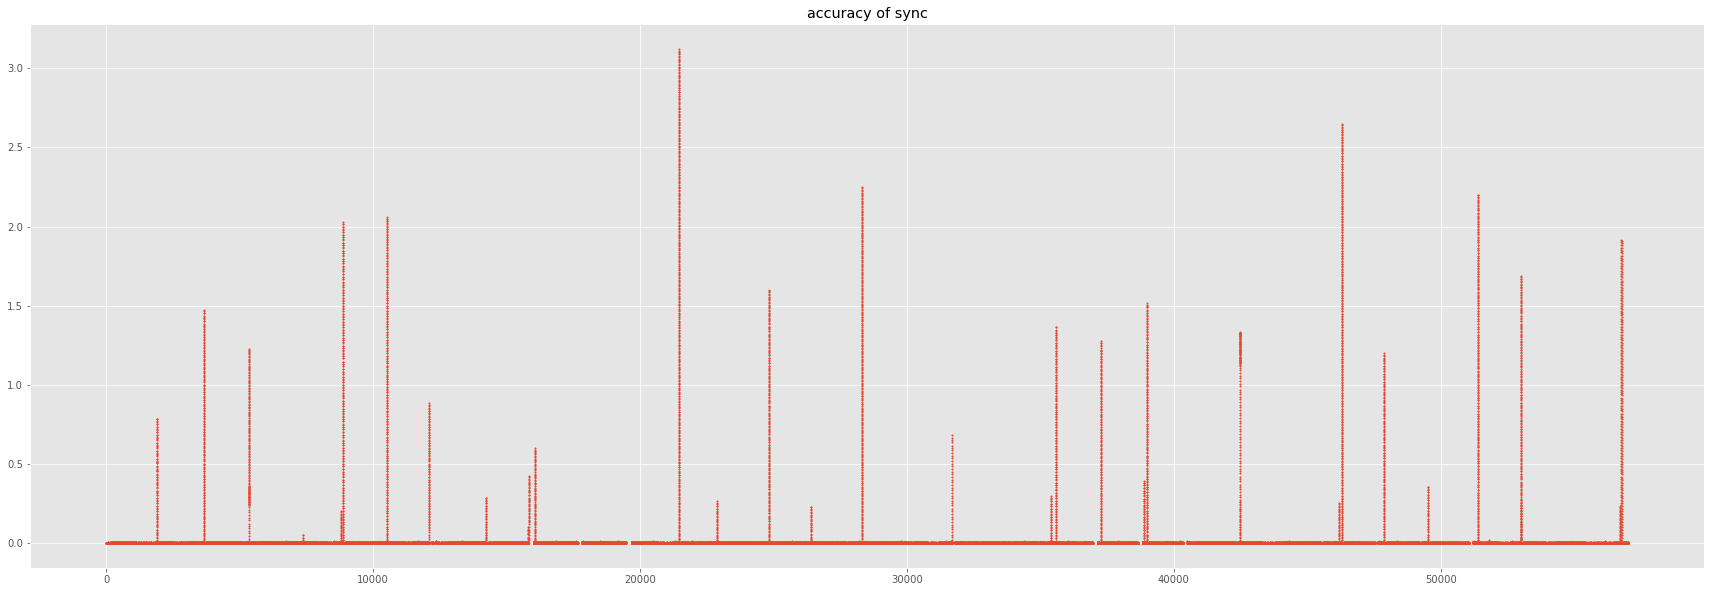

In [176]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title('accuracy of sync')
plt.scatter(STTLs[:,2],SA[:,2],s=2)


In [41]:
ts_list


[0          16.309200
 1          16.320168
 2          16.336666
 3          16.355734
 4          16.370068
             ...     
 58804    1010.219177
 58805    1010.235718
 58806    1010.257751
 58807    1010.269226
 58808    1010.285706
 Name: R_eye_TTL, Length: 58809, dtype: float64,
 0           4.181233
 1           4.198267
 2           4.215267
 3           4.232300
 4           4.249333
             ...     
 62581    1069.493530
 62582    1069.510498
 62583    1069.527588
 62584    1069.544556
 62585    1069.561646
 Name: Arena_TTL, Length: 62586, dtype: float64,
 0          16.307766
 1          16.317467
 2          16.334101
 3          16.353167
 4          16.367332
             ...     
 57021    1010.218689
 57022    1010.234924
 57023    1010.253845
 57024    1010.268005
 57025    1010.284668
 Name: L_eye_TTL, Length: 57026, dtype: float64]

In [104]:
right_eye_ellipses = pd.read_csv(r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_R\ellipsefit.csv')
left_eye_ellipses = pd.read_csv(r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_L\ellipsefit.csv')

In [105]:
np.array(right_eye_ellipses['ellipse_size'][0])

array(3234.5446239)

In [85]:
print(len(STTLs[:,0]))
print(len(right_eye_ellipses))
print(STTLs[0:len(right_eye_ellipses),0])

58809
58808
[    0     1     2 ... 58805 58806 58807]


In [ ]:
left_eye_sync_size = []
for i in STTLs[:,2]:
    if i <= len(left_eye_ellipses):
        left_eye_sync_size.append(left_eye_ellipses['ellipse_size'][STTLs[i,2]])
    else:
        left_eye_sync_size.append(0)
left_eye_sync_size


In [167]:
plot_r = np.array(right_eye_ellipses['ellipse_size'])
plot_r[right_eye_ellipses['ellipse_size']>6000] = 0
plot_l = np.array(left_eye_sync_size)
plot_l[np.array(left_eye_sync_size) > 6000] = 0
plot_l

array([4268.31676165, 4276.08723908, 4262.3871212 , ...,    0.        ,
          0.        ,    0.        ])

In [ ]:
eye_led_off_frames = pd.read_csv(r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\eye_tracking_led_off_frames.csv')
eye_led_off_frames

In [179]:
led_off_left_eye = np.array(eye_led_off_frames['AzulaTrial5_30_12_Left'])
led_off_right_eye = np.array(eye_led_off_frames['AzulaTrial5_30_12_Right'])

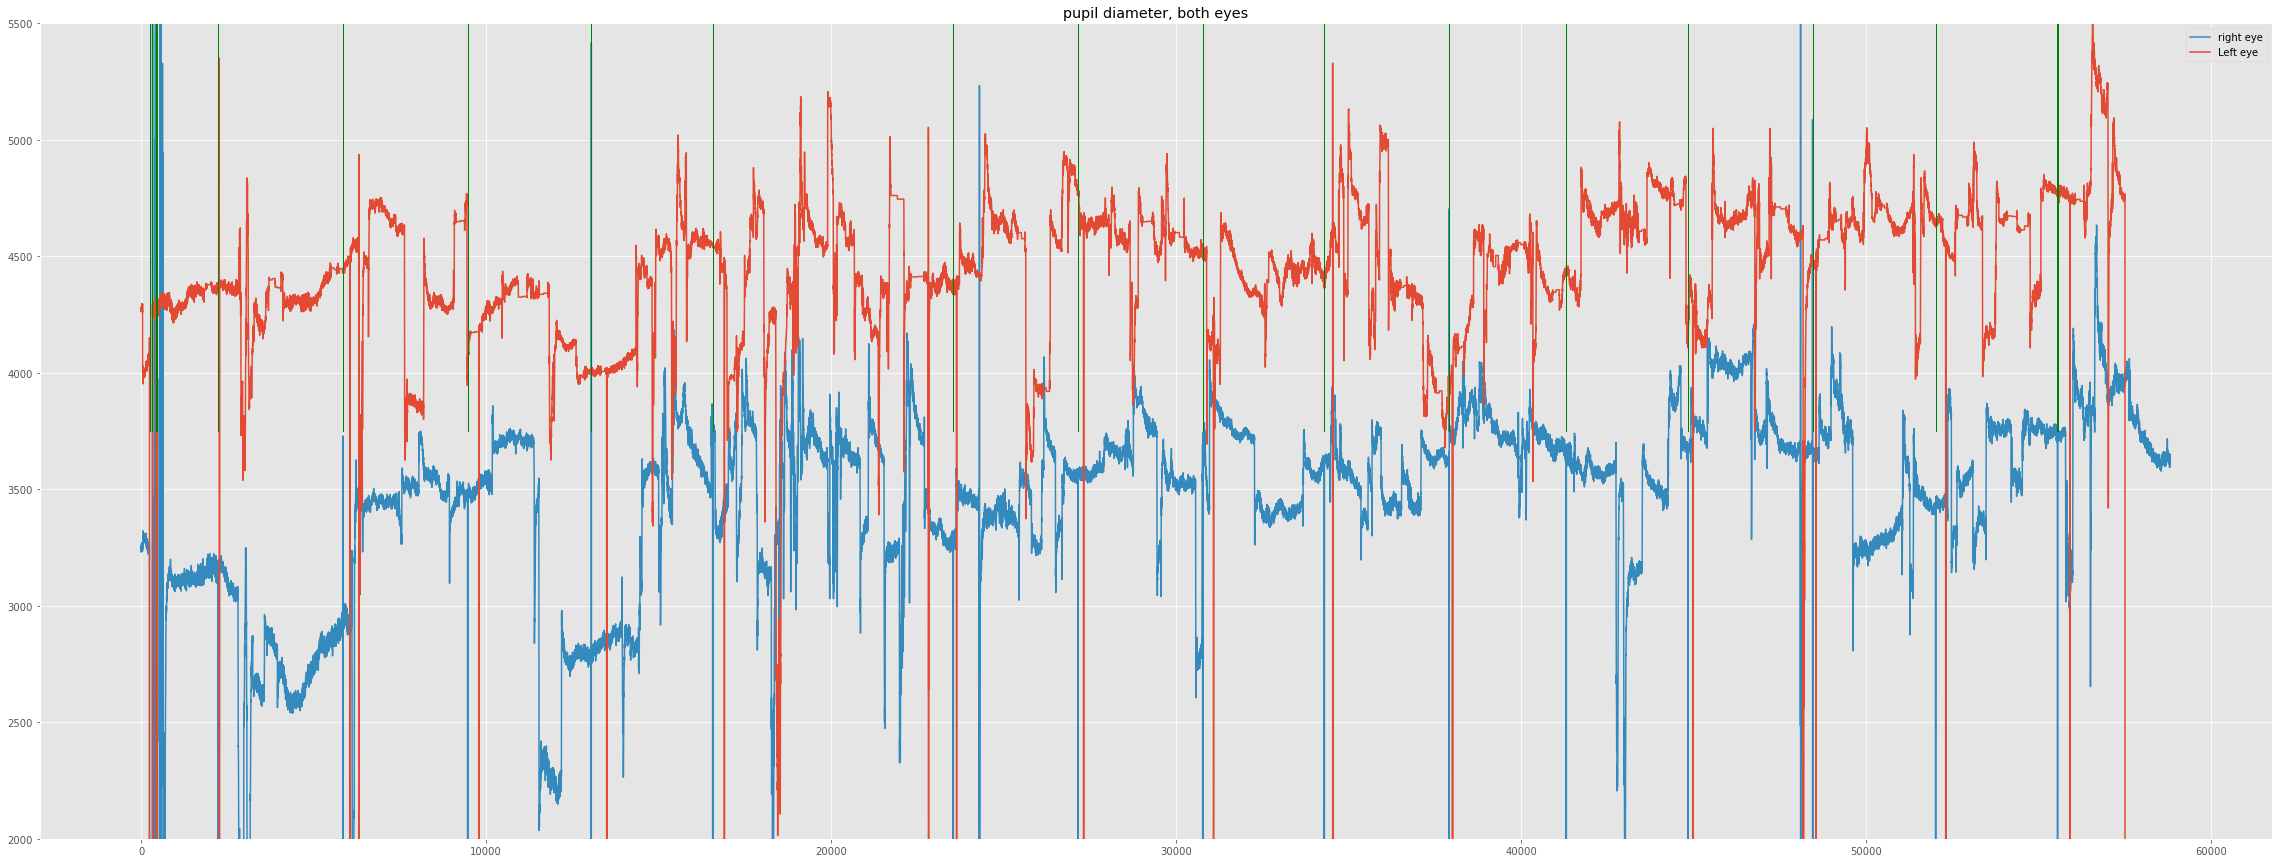

In [267]:
fig, ax = plt.subplots(figsize=(40, 15))
ax.set_title('pupil diameter, both eyes')
plt.plot(STTLs[0:len(right_eye_ellipses),0],plot_r,'C1', label='right eye')
plt.plot(STTLs[0:len(right_eye_ellipses),0],plot_l[0:-1],'C0', label='Left eye')
for i in list(led_off_right_eye):
        plt.axvline(i, linewidth=1, color='g', ymin=0.5)
plt.ylim(top = 5500, bottom=2000)
plt.legend()

In [ ]:
vid_paths = [
    r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_L\AzulaTrial5_30_12L.mp4',
    r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_R\AzulaTrial5_30_12.mp4'
            ]

def eye_tracking_frame_val(vid_paths):

    #create the vidnames
    vidnames = []
    for vid in vid_paths:
        vidname = vid.split(sep="\\") ; vidname = vidname[len(vidname)-1]; vidname=vidname.split(sep='.') ; vidname=vidname[0]
        vidnames.append(vidname)
    print(vidnames)
    frame_val_list = []
    for vid in vid_paths:
        print(f'working on video {vid}')
        frame_val = uf.arena_video_initial_thr(vid, 30)
        frame_val_list.append(frame_val)
    print(f'done, frame_val_list contains {len(frame_val_list)} objects',flush=True)

    return vidnames, frame_val_list

vidnames, frame_val_list = eye_tracking_frame_val(vid_paths)

In [218]:
STTLs[0,2]

0

In [225]:
np.array(frame_val_list[0])[1,1]

84.940009765625

In [ ]:
left_eye_sync_fv = []
for i in STTLs[:,2]:
    if i <= len(frame_val_list[1][0]):
        left_eye_sync_fv.append(np.array(frame_val_list[0])[1,STTLs[i,2]])
    else:
        left_eye_sync_fv.append(0)


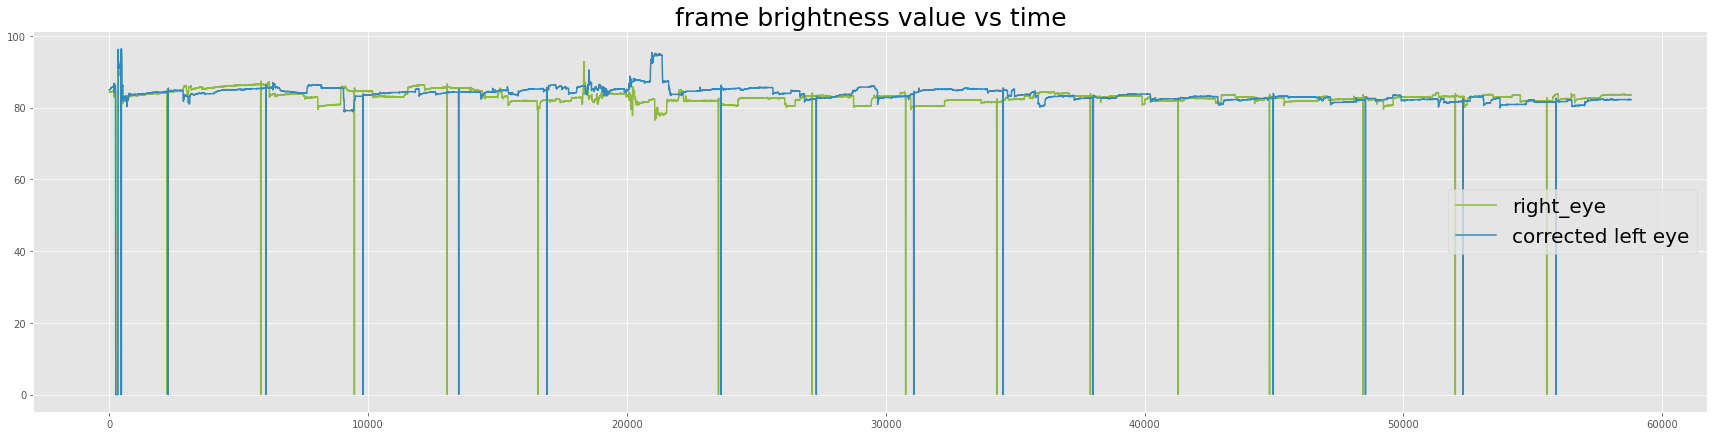

In [281]:
fig, ax = plt.subplots(figsize=(30,7))
ax.set_title('frame brightness value vs time', fontsize=25)
plt.plot(frame_val_list[1][0],frame_val_list[1][1], 'C5', label='right_eye')
plt.plot(frame_val_list[1][0], left_eye_sync_fv, 'C1', label='corrected left eye')
#plt.plot(frame_val_list[0][0], frame_val_list[0][1], 'C2', label='left eye (native timing)')
plt.legend(prop={'size': 20})

In [283]:
ts_list[0]

0          16.309200
1          16.320168
2          16.336666
3          16.355734
4          16.370068
            ...     
58804    1010.219177
58805    1010.235718
58806    1010.257751
58807    1010.269226
58808    1010.285706
Name: R_eye_TTL, Length: 58809, dtype: float64